<a href="https://colab.research.google.com/github/giosanchez0208/CSC173-DeepCV-Sanchez/blob/main/refine_segmentation_model_safe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup: Google Colab Environment

In [21]:
# Check GPU availability
import torch
import os
import sys

# Verify CUDA is available
if torch.cuda.is_available():
    device = 'cuda'
    print(f'GPU available: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')
else:
    device = 'cpu'
    print('No GPU available, using CPU (training will be slow)')

print(f'\nPyTorch version: {torch.__version__}')
print(f'CUDA version: {torch.version.cuda}')

GPU available: Tesla T4
Memory: 15.83 GB

PyTorch version: 2.9.0+cu126
CUDA version: 12.6


In [22]:
# Install required packages
!pip install -q ultralytics opencv-python-headless pillow pyyaml numpy scipy matplotlib pandas gdown

print('All packages installed successfully')


All packages installed successfully


## Dataset and Model Download (Reproducible Setup)

In [23]:
import os
import gdown
import zipfile
import yaml
from pathlib import Path
import shutil

# Public Google Drive folder for the dataset
PUBLIC_DRIVE_FOLDER = 'https://drive.google.com/drive/folders/1rYbZXSwnd0DQ49VP_04C8OYkhU6b4p-t'
DATASET_ZIP_ID = '1GKtBNb8FNBdLfc5QngCFhRqNB-XjcBId'
PRETRAINED_MODEL_ID = '1v8NkcQavobGCrAfYx7YnlYVH4nCpz6PZ'

# Local paths
LOCAL_ROOT = '/content/ocr_project'
DATASET_ZIP_PATH = f'{LOCAL_ROOT}/dataset.zip'
LOCAL_DATASET_PATH = f'{LOCAL_ROOT}/dataset'
LOCAL_MODELS_PATH = f'{LOCAL_ROOT}/models'
LOCAL_CHECKPOINTS_PATH = f'{LOCAL_ROOT}/checkpoints'

# Create directories
for path in [LOCAL_ROOT, LOCAL_MODELS_PATH, LOCAL_CHECKPOINTS_PATH]:
    Path(path).mkdir(parents=True, exist_ok=True)

print('Directory structure created:')
print(f'  Root: {LOCAL_ROOT}')
print(f'  Dataset: {LOCAL_DATASET_PATH}')
print(f'  Models: {LOCAL_MODELS_PATH}')
print(f'  Checkpoints: {LOCAL_CHECKPOINTS_PATH}')

Directory structure created:
  Root: /content/ocr_project
  Dataset: /content/ocr_project/dataset
  Models: /content/ocr_project/models
  Checkpoints: /content/ocr_project/checkpoints


In [24]:
def download_file_from_drive(file_id, output_path, retries=3):
    """Download a file from Google Drive using gdown."""
    url = f'https://drive.google.com/uc?id={file_id}'

    for attempt in range(retries):
        try:
            print(f'Download attempt {attempt + 1}/{retries} for {output_path}')
            gdown.download(url, output_path, quiet=False)

            if os.path.exists(output_path) and os.path.getsize(output_path) > 0:
                print(f'Successfully downloaded: {output_path}')
                print(f'File size: {os.path.getsize(output_path) / (1024**2):.2f} MB')
                return True
            else:
                print(f'Download failed: file is empty or does not exist')

        except Exception as e:
            print(f'Download attempt {attempt + 1} failed: {e}')

    return False

# Download dataset if not already present
if not os.path.exists(DATASET_ZIP_PATH):
    print('Downloading dataset...')
    # IMPORTANT: Replace with actual file ID from your public folder
    # You need to get the actual file ID for dataset.zip
    success = download_file_from_drive(DATASET_ZIP_ID, DATASET_ZIP_PATH)
    if not success:
        print('ERROR: Failed to download dataset. Please check the file ID.')
        print(f'Public folder: {PUBLIC_DRIVE_FOLDER}')
        print('Please update DATASET_ZIP_ID with the actual file ID from the dataset.zip file')
        raise FileNotFoundError('Dataset download failed')
else:
    print(f'Dataset already exists at: {DATASET_ZIP_PATH}')

# Download pretrained model if not already present
PRETRAINED_MODEL_PATH = f'{LOCAL_MODELS_PATH}/custom_ocr_last.pt'
if not os.path.exists(PRETRAINED_MODEL_PATH):
    print('\nDownloading pretrained model...')
    # IMPORTANT: Replace with actual file ID from your public folder
    # You need to get the actual file ID for custom_ocr_last.pt
    success = download_file_from_drive(PRETRAINED_MODEL_ID, PRETRAINED_MODEL_PATH)
    if not success:
        print('WARNING: Failed to download pretrained model. Training will start from scratch.')
        PRETRAINED_MODEL_PATH = None
else:
    print(f'Pretrained model already exists at: {PRETRAINED_MODEL_PATH}')

Dataset already exists at: /content/ocr_project/dataset.zip
Pretrained model already exists at: /content/ocr_project/models/custom_ocr_last.pt


In [25]:
# Extract dataset if not already extracted
if not os.path.exists(LOCAL_DATASET_PATH) or not os.path.exists(f'{LOCAL_DATASET_PATH}/data.yaml'):
    print('\nExtracting dataset...')

    if not os.path.exists(DATASET_ZIP_PATH):
        print(f'ERROR: Dataset zip not found at {DATASET_ZIP_PATH}')
        raise FileNotFoundError('Dataset zip file not found')

    try:
        with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(LOCAL_ROOT)

        # Check if extraction created a nested 'dataset' folder
        extracted_paths = list(Path(LOCAL_ROOT).glob('**/data.yaml'))

        if extracted_paths:
            # Found data.yaml somewhere
            data_yaml_path = str(extracted_paths[0])
            dataset_parent = str(extracted_paths[0].parent)

            # If it's not in the expected location, move it
            if dataset_parent != LOCAL_DATASET_PATH:
                print(f'Moving dataset from {dataset_parent} to {LOCAL_DATASET_PATH}')
                if os.path.exists(LOCAL_DATASET_PATH):
                    shutil.rmtree(LOCAL_DATASET_PATH)
                shutil.move(dataset_parent, LOCAL_DATASET_PATH)

        print(f'Dataset extracted to: {LOCAL_DATASET_PATH}')

    except Exception as e:
        print(f'ERROR: Failed to extract dataset: {e}')
        raise
else:
    print(f'Dataset already extracted at: {LOCAL_DATASET_PATH}')

# Verify data.yaml exists
DATA_YAML_PATH = f'{LOCAL_DATASET_PATH}/data.yaml'
if not os.path.exists(DATA_YAML_PATH):
    print(f'ERROR: data.yaml not found at {DATA_YAML_PATH}')
    print('Looking for data.yaml in extracted files...')

    # Search for data.yaml
    for root, dirs, files in os.walk(LOCAL_ROOT):
        if 'data.yaml' in files:
            DATA_YAML_PATH = os.path.join(root, 'data.yaml')
            print(f'Found data.yaml at: {DATA_YAML_PATH}')
            break

    if not os.path.exists(DATA_YAML_PATH):
        raise FileNotFoundError(f'data.yaml not found in {LOCAL_ROOT}')

print(f'\nData configuration: {DATA_YAML_PATH}')
print(f'Pretrained model: {PRETRAINED_MODEL_PATH if PRETRAINED_MODEL_PATH else "None (starting from scratch)"}')

Dataset already extracted at: /content/ocr_project/dataset

Data configuration: /content/ocr_project/dataset/data.yaml
Pretrained model: /content/ocr_project/models/custom_ocr_last.pt


In [26]:
# Sanity check: Verify dataset structure
print('\n=== DATASET SANITY CHECK ===')

required_folders = ['train/images', 'train/labels',
                    'val/images', 'val/labels',
                    'test/images', 'test/labels']

all_good = True
for folder in required_folders:
    folder_path = f'{LOCAL_DATASET_PATH}/{folder}'
    if os.path.exists(folder_path):
        file_count = len(os.listdir(folder_path))
        print(f'{folder}: {file_count} files')
    else:
        print(f'{folder}: NOT FOUND')
        all_good = False

# Check data.yaml content
try:
    with open(DATA_YAML_PATH, 'r') as f:
        data_config = yaml.safe_load(f)

    print(f'\ndata.yaml content:')
    print(f'  Classes: {len(data_config.get("names", []))}')
    print(f'  Path: {data_config.get("path", "Not specified")}')
    print(f'  Train: {data_config.get("train", "Not specified")}')
    print(f'  Val: {data_config.get("val", "Not specified")}')

    # Fix paths in data.yaml if they're wrong
    if data_config.get('path') != LOCAL_DATASET_PATH:
        print(f'\nFixing data.yaml paths...')
        data_config['path'] = LOCAL_DATASET_PATH
        data_config['train'] = 'train/images'
        data_config['val'] = 'val/images'
        data_config['test'] = 'test/images'

        with open(DATA_YAML_PATH, 'w') as f:
            yaml.dump(data_config, f, default_flow_style=False)
        print(f'  Updated paths in data.yaml')

except Exception as e:
    print(f'ERROR reading data.yaml: {e}')
    all_good = False

if all_good:
    print('\nAll dataset checks passed')
else:
    print('\nDataset has issues. Please check the structure.')
    raise ValueError('Dataset structure is incorrect')


=== DATASET SANITY CHECK ===
train/images: 15960 files
train/labels: 15960 files
val/images: 2000 files
val/labels: 2000 files
test/images: 2000 files
test/labels: 2000 files

data.yaml content:
  Classes: 36
  Path: /content/ocr_project/dataset
  Train: train/images
  Val: val/images

All dataset checks passed


## Enhanced Checkpoint Management System

In [27]:
import pandas as pd
import json
import time
import threading
from datetime import datetime
from pathlib import Path

class CheckpointManager:
    """
    Robust checkpoint management system that:
    1. Saves CSV progress every epoch
    2. Saves model checkpoints to Google Drive every epoch
    3. Maintains detailed training history
    4. Allows resuming from any point
    """

    def __init__(self, experiment_name, local_checkpoint_dir, drive_checkpoint_dir=None):
        """
        Initialize checkpoint manager.

        Args:
            experiment_name: Name for this training run
            local_checkpoint_dir: Local directory for fast checkpoint access
            drive_checkpoint_dir: Google Drive directory for permanent storage (optional)
        """
        self.experiment_name = experiment_name
        self.local_dir = Path(local_checkpoint_dir) / experiment_name
        self.drive_dir = Path(drive_checkpoint_dir) / experiment_name if drive_checkpoint_dir else None

        # Create directories
        self.local_dir.mkdir(parents=True, exist_ok=True)
        if self.drive_dir:
            self.drive_dir.mkdir(parents=True, exist_ok=True)

        # File paths
        self.csv_path = self.local_dir / 'training_progress.csv'
        self.config_path = self.local_dir / 'training_config.json'
        self.best_model_local = self.local_dir / 'best_model.pt'
        self.last_model_local = self.local_dir / 'last_model.pt'

        if self.drive_dir:
            self.best_model_drive = self.drive_dir / 'best_model.pt'
            self.last_model_drive = self.drive_dir / 'last_model.pt'
            self.csv_drive = self.drive_dir / 'training_progress.csv'

        # Initialize CSV if it doesn't exist
        self._initialize_csv()

        print(f'Checkpoint Manager initialized:')
        print(f'  Experiment: {experiment_name}')
        print(f'  Local directory: {self.local_dir}')
        if self.drive_dir:
            print(f'  Drive directory: {self.drive_dir}')

    def _initialize_csv(self):
        """Initialize CSV with required columns."""
        if not self.csv_path.exists():
            columns = [
                'epoch', 'timestamp',
                'train/cls_loss', 'val/cls_loss',
                'train/seg_loss', 'val/seg_loss',
                'train/box_loss', 'val/box_loss',
                'metrics/precision(M)', 'metrics/recall(M)',
                'metrics/mAP50(M)', 'metrics/mAP50-95(M)',
                'learning_rate', 'phase',
                'ocr_char_accuracy', 'ocr_top2_accuracy', 'ocr_top3_accuracy'
            ]
            pd.DataFrame(columns=columns).to_csv(self.csv_path, index=False)

    def save_config(self, config):
        """Save training configuration."""
        with open(self.config_path, 'w') as f:
            json.dump(config, f, indent=2)

        # Also save to drive if available
        if self.drive_dir:
            drive_config_path = self.drive_dir / 'training_config.json'
            with open(drive_config_path, 'w') as f:
                json.dump(config, f, indent=2)

    def save_progress(self, epoch, metrics, model_path=None, is_best=False):
        """
        Save training progress for an epoch.

        Args:
            epoch: Current epoch number
            metrics: Dictionary of metrics
            model_path: Path to model file to save
            is_best: Whether this is the best model so far
        """
        # Add epoch and timestamp to metrics
        metrics['epoch'] = epoch
        metrics['timestamp'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        # Load existing CSV and append new row
        df = pd.read_csv(self.csv_path) if self.csv_path.exists() else pd.DataFrame()
        new_row = pd.DataFrame([metrics])
        df = pd.concat([df, new_row], ignore_index=True)

        # Save to local CSV
        df.to_csv(self.csv_path, index=False)

        # Save model if provided
        if model_path and Path(model_path).exists():
            # Save last model
            shutil.copy2(model_path, self.last_model_local)

            # Save best model if applicable
            if is_best:
                shutil.copy2(model_path, self.best_model_local)
                print(f'  [Checkpoint] New best model saved (epoch {epoch})')

            # Async save to Google Drive
            if self.drive_dir:
                self._async_save_to_drive(model_path, is_best)

        # Async save CSV to Google Drive
        if self.drive_dir:
            self._async_save_csv_to_drive()

        print(f'[Checkpoint] Progress saved for epoch {epoch}')

    def _async_save_to_drive(self, model_path, is_best):
        """Asynchronously save model to Google Drive."""
        def save_task():
            try:
                # Save last model
                shutil.copy2(model_path, self.last_model_drive)

                # Save best model if applicable
                if is_best:
                    shutil.copy2(model_path, self.best_model_drive)

                print(f'  [Checkpoint] Model backed up to Drive')
            except Exception as e:
                print(f'  [Checkpoint] Warning: Failed to save model to Drive: {e}')

        # Start async save
        thread = threading.Thread(target=save_task, daemon=True)
        thread.start()

    def _async_save_csv_to_drive(self):
        """Asynchronously save CSV to Google Drive."""
        def save_task():
            try:
                shutil.copy2(self.csv_path, self.csv_drive)
            except Exception as e:
                print(f'  [Checkpoint] Warning: Failed to save CSV to Drive: {e}')

        thread = threading.Thread(target=save_task, daemon=True)
        thread.start()

    def get_last_checkpoint(self):
        """Get information about the last checkpoint."""
        info = {
            'exists': False,
            'last_epoch': 0,
            'best_model_path': None,
            'last_model_path': None
        }

        # Check local first
        if self.csv_path.exists():
            df = pd.read_csv(self.csv_path)
            if len(df) > 0:
                info['exists'] = True
                info['last_epoch'] = int(df['epoch'].iloc[-1])

                # Check for model files
                if self.last_model_local.exists():
                    info['last_model_path'] = str(self.last_model_local)
                if self.best_model_local.exists():
                    info['best_model_path'] = str(self.best_model_local)

        return info

    def load_progress(self):
        """Load training progress from CSV."""
        if self.csv_path.exists():
            return pd.read_csv(self.csv_path)
        return pd.DataFrame()

# Initialize checkpoint manager
experiment_name = f'refine_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
checkpoint_manager = CheckpointManager(
    experiment_name=experiment_name,
    local_checkpoint_dir=LOCAL_CHECKPOINTS_PATH,
    drive_checkpoint_dir=None  # Will be set after mounting Drive
)

print('\nCheckpoint system ready. CSV will be saved every epoch.')

Checkpoint Manager initialized:
  Experiment: refine_20251224_015558
  Local directory: /content/ocr_project/checkpoints/refine_20251224_015558

Checkpoint system ready. CSV will be saved every epoch.


## Mount Google Drive for Permanent Storage (Optional)

In [28]:
# Mount Google Drive if available
DRIVE_CHECKPOINT_DIR = None
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # Set up Drive checkpoint directory
    DRIVE_CHECKPOINT_DIR = f'/content/drive/MyDrive/ocr_checkpoints'
    os.makedirs(DRIVE_CHECKPOINT_DIR, exist_ok=True)

    # Update checkpoint manager with Drive directory
    checkpoint_manager.drive_dir = Path(DRIVE_CHECKPOINT_DIR) / experiment_name
    checkpoint_manager.drive_dir.mkdir(parents=True, exist_ok=True)

    checkpoint_manager.best_model_drive = checkpoint_manager.drive_dir / 'best_model.pt'
    checkpoint_manager.last_model_drive = checkpoint_manager.drive_dir / 'last_model.pt'
    checkpoint_manager.csv_drive = checkpoint_manager.drive_dir / 'training_progress.csv'

    print(f'Google Drive mounted successfully')
    print(f'Checkpoints will be saved to: {DRIVE_CHECKPOINT_DIR}')

except Exception as e:
    print(f'Note: Google Drive not mounted. Checkpoints will only be saved locally.')
    print(f'Error: {e}')

# Save training configuration
training_config = {
    'experiment_name': experiment_name,
    'dataset_path': LOCAL_DATASET_PATH,
    'pretrained_model': PRETRAINED_MODEL_PATH,
    'data_yaml': DATA_YAML_PATH,
    'device': device,
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

checkpoint_manager.save_config(training_config)
print(f'Training configuration saved')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully
Checkpoints will be saved to: /content/drive/MyDrive/ocr_checkpoints
Training configuration saved


## Core Components (Reused from Original Training)

In [29]:
# Character set and similarity matrix (from original)
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

CHARS = [chr(i) for i in range(65, 91)] + [str(i) for i in range(10)]
NUM_CLASSES = len(CHARS)
CHAR_TO_IDX = {c: i for i, c in enumerate(CHARS)}
IDX_TO_CHAR = {i: c for i, c in enumerate(CHARS)}

print(f'Number of classes: {NUM_CLASSES}')
print(f'Characters: {"".join(CHARS)}')

SIMILAR_GROUPS = [
    ['O', '0'],
    ['I', '1'],
    ['S', '5'],
    ['Z', '2'],
    ['B', '8'],
    ['D', '0'],
    ['G', 'C'],
    ['U', 'V'],
    ['P', 'R'],
]

def create_similarity_matrix(num_classes=NUM_CLASSES, groups=SIMILAR_GROUPS, base_sim=0.6):
    S = np.zeros((num_classes, num_classes), dtype=np.float32)
    np.fill_diagonal(S, 1.0)
    for group in groups:
        idxs = [CHAR_TO_IDX[c] for c in group if c in CHAR_TO_IDX]
        for i in idxs:
            for j in idxs:
                if i != j:
                    S[i, j] = base_sim
    return torch.tensor(S, dtype=torch.float32)

similarity_matrix = create_similarity_matrix()
print(f'Similarity matrix initialized: {similarity_matrix.shape}')

Number of classes: 36
Characters: ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
Similarity matrix initialized: torch.Size([36, 36])


In [30]:
# Enhanced Similarity-Aware Loss with Adaptive Weighting
class RefinedSimilarityAwareTopKLoss(nn.Module):
    """
    Enhanced loss for fine-tuning with:
    - Higher penalty for similar character confusion
    - Adaptive temperature based on training phase
    - Confidence-based weighting
    """
    def __init__(self, num_classes=NUM_CLASSES, similarity_matrix=None,
                 k=3, initial_temperature=0.5, base_weight=0.5, topk_weight=0.5,
                 epochs=40):
        super().__init__()
        self.num_classes = num_classes
        self.k = k
        self.initial_temperature = initial_temperature
        self.base_weight = base_weight
        self.topk_weight = topk_weight
        self.epochs = epochs
        self.current_epoch = 0

        if similarity_matrix is not None:
            self.register_buffer('similarity_matrix', similarity_matrix)
        else:
            self.register_buffer('similarity_matrix', create_similarity_matrix())

    def update_epoch(self, epoch):
        """Update current epoch for temperature annealing."""
        self.current_epoch = epoch

    def get_temperature(self):
        """Anneal temperature more aggressively for fine-tuning."""
        progress = self.current_epoch / max(self.epochs, 1)
        # Start at 0.5, go to 0.3 (sharper predictions)
        return max(0.3, self.initial_temperature - progress * 0.2)

    def forward(self, logits, targets):
        B = logits.size(0)
        device = logits.device

        temperature = self.get_temperature()

        # Standard cross-entropy
        ce_loss = F.cross_entropy(logits, targets, reduction='none')

        # Softmax with temperature
        probs = F.softmax(logits / temperature, dim=1)
        topk_probs, topk_indices = torch.topk(probs, min(self.k, self.num_classes), dim=1)

        # Similarity-aware penalty
        sim_loss = torch.zeros(B, device=device)
        confidence_scores = []

        for i in range(B):
            t = targets[i].item()
            if t < 0 or t >= self.num_classes:
                continue

            sims = self.similarity_matrix[t][topk_indices[i]]

            # Higher penalty for similar character confusion
            penalties = (1.0 - sims) * 1.5  # Amplify penalty
            weighted_penalties = topk_probs[i] * penalties
            sim_loss[i] = weighted_penalties.sum()

            confidence_scores.append(topk_probs[i][0].item())

        if len(confidence_scores) == 0:
            return ce_loss.mean()

        # Adaptive weighting based on confidence
        confidence = torch.tensor(confidence_scores, device=device)

        # When confident: rely more on CE (trust the model)
        # When uncertain: rely more on similarity (guide the model)
        adaptive_base = self.base_weight + (1 - confidence) * 0.2
        adaptive_topk = self.topk_weight + confidence * 0.2

        # Normalize
        total_weight = adaptive_base + adaptive_topk
        adaptive_base = adaptive_base / total_weight
        adaptive_topk = adaptive_topk / total_weight

        total_loss = adaptive_base * ce_loss + adaptive_topk * sim_loss
        return total_loss.mean()

print('Refined similarity-aware loss defined')

Refined similarity-aware loss defined


In [31]:
# OCR Metrics (reused from original)
class OCRMetrics:
    """Compute OCR-specific validation metrics."""
    def __init__(self, similarity_matrix=None):
        self.similarity_matrix = similarity_matrix if similarity_matrix is not None else create_similarity_matrix()
        self.reset()

    def reset(self):
        self.total_chars = 0
        self.correct_chars = 0
        self.top2_correct = 0
        self.top3_correct = 0
        self.similarity_score = 0.0

    def update(self, predictions, targets, top_k_preds=None):
        predictions = predictions.cpu().numpy()
        targets = targets.cpu().numpy()

        self.total_chars += len(targets)
        self.correct_chars += (predictions == targets).sum()

        # Similarity-aware accuracy
        for pred, target in zip(predictions, targets):
            if 0 <= target < len(self.similarity_matrix) and 0 <= pred < len(self.similarity_matrix):
                sim = self.similarity_matrix[target][pred].item()
                self.similarity_score += sim

        # Top-k accuracy
        if top_k_preds is not None:
            top_k_preds = top_k_preds.cpu().numpy()
            for i, target in enumerate(targets):
                if top_k_preds.shape[1] >= 2 and target in top_k_preds[i, :2]:
                    self.top2_correct += 1
                if top_k_preds.shape[1] >= 3 and target in top_k_preds[i, :3]:
                    self.top3_correct += 1

    def compute(self):
        if self.total_chars == 0:
            return {}

        return {
            'ocr_char_accuracy': self.correct_chars / self.total_chars,
            'ocr_top2_accuracy': self.top2_correct / self.total_chars,
            'ocr_top3_accuracy': self.top3_correct / self.total_chars,
            'ocr_similarity_aware_accuracy': self.similarity_score / self.total_chars,
        }

print('OCR metrics module loaded')

OCR metrics module loaded


## Enhanced Trainer with Checkpoint Integration

In [32]:
# Custom Trainer for Refined Training (FIXED)
from ultralytics.models.yolo.segment import SegmentationTrainer
from ultralytics import YOLO

class RefinedSegmentationTrainer(SegmentationTrainer):
    """
    Refined trainer with:
    - Progressive layer unfreezing
    - Enhanced loss function
    - OCR-specific metrics tracking
    - Integrated checkpoint management
    """

    def __init__(self, cfg=None, overrides=None, _callbacks=None, checkpoint_manager=None):
        # Initialize overrides if not provided
        if overrides is None:
            overrides = {}

        # *** CRITICAL FIX: Remove deprecated arguments ***
        if 'task' in overrides:
            print("Removing deprecated 'task' argument from overrides.")
            del overrides['task']
        if 'compile' in overrides:
            print("Removing deprecated 'compile' argument from overrides.")
            del overrides['compile']

        # Ensure other critical defaults are set if missing
        # 'model' is the most important; it must be in cfg or overrides
        if 'model' not in cfg and 'model' not in overrides:
            # Try to get model path from the global variable you set earlier
            global model_path
            if 'model_path' in globals():
                overrides['model'] = model_path
                print(f"Setting model path in overrides: {model_path}")

        super().__init__(cfg, overrides, _callbacks)

    def _setup_train(self, world_size=1):
        """Override to apply layer freezing for Phase 1."""
        super()._setup_train(world_size)

        if not self.freeze_applied and self.epoch < 12:
            print(f'\nPHASE 1: Classifier Head Fine-Tuning (Epochs 1-12)')
            print('Freezing backbone and segmentation layers...')

            # Freeze all layers except classification head
            for name, param in self.model.named_parameters():
                # Keep classification layers trainable
                if 'cls' in name.lower() or 'cv3' in name.lower():
                    param.requires_grad = True
                else:
                    param.requires_grad = False

            trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
            total = sum(p.numel() for p in self.model.parameters())
            print(f'Trainable parameters: {trainable:,} / {total:,} ({100*trainable/total:.1f}%)')
            self.freeze_applied = True

    def on_train_epoch_start(self):
        """Handle phase transitions and progressive unfreezing."""
        super().on_train_epoch_start()

        # Update temperature in loss
        self.character_loss_fn.update_epoch(self.epoch)

        # Phase 2: Progressive unfreezing (epochs 12-24)
        if self.epoch == 12:
            self.phase = 2
            print(f'\nPHASE 2: Progressive Unfreezing (Epochs 13-24)')
            print('Unfreezing segmentation head...')

            for name, param in self.model.named_parameters():
                if 'seg' in name.lower() or 'mask' in name.lower():
                    param.requires_grad = True

            trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
            total = sum(p.numel() for p in self.model.parameters())
            print(f'Trainable parameters: {trainable:,} / {total:,} ({100*trainable/total:.1f}%)')

        # Phase 3: Full fine-tuning (epochs 24+)
        elif self.epoch == 24:
            self.phase = 3
            print(f'\nPHASE 3: Full Fine-Tuning (Epochs 25-40)')
            print('Unfreezing all layers...')

            for param in self.model.parameters():
                param.requires_grad = True

            trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
            total = sum(p.numel() for p in self.model.parameters())
            print(f'Trainable parameters: {trainable:,} / {total:,} ({100*trainable/total:.1f}%)')

    def on_train_epoch_end(self):
        """Save checkpoint after each epoch."""
        super().on_train_epoch_end()

        if self.checkpoint_manager:
            # Collect metrics
            metrics = self._collect_metrics()

            # Determine if this is the best model
            current_cls_loss = metrics.get('val/cls_loss', float('inf'))
            is_best = current_cls_loss < self.best_cls_loss

            if is_best:
                self.best_cls_loss = current_cls_loss

            # Save progress
            model_path = Path(self.save_dir) / 'weights' / 'last.pt'
            self.checkpoint_manager.save_progress(
                epoch=self.epoch,
                metrics=metrics,
                model_path=str(model_path) if model_path.exists() else None,
                is_best=is_best
            )

    def _collect_metrics(self, trainer):
        """Collect metrics from trainer - FIXED VERSION."""
        metrics = {
            'epoch': self.current_epoch,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'phase': getattr(trainer, 'phase', 1),
        }

        # Get learning rate
        if hasattr(trainer, 'optimizer') and trainer.optimizer:
            metrics['learning_rate'] = trainer.optimizer.param_groups[0]['lr']

        # Try to get losses from different places YOLO stores them
        if hasattr(trainer, 'loss_names') and hasattr(trainer, 'loss'):
            # YOLO stores losses in trainer.loss (tensor) with names in loss_names
            loss_names = trainer.loss_names
            loss_values = trainer.loss.cpu().detach().numpy() if trainer.loss is not None else []

            # Map common loss names
            loss_mapping = {
                'box_loss': ('train/box_loss', 0),
                'seg_loss': ('train/seg_loss', 1),
                'cls_loss': ('train/cls_loss', 2),
                'dfl_loss': ('train/dfl_loss', 3)
            }

            for loss_name, (metric_name, idx) in loss_mapping.items():
                if loss_name in loss_names and idx < len(loss_values):
                    metrics[metric_name] = float(loss_values[idx])

        # Try to read from YOLO's results.csv (most reliable!)
        results_csv = f"{trainer.save_dir}/results.csv"
        if os.path.exists(results_csv):
            try:
                df = pd.read_csv(results_csv)
                if not df.empty and self.current_epoch <= len(df):
                    # Get the row for current epoch (0-indexed)
                    row_idx = min(self.current_epoch - 1, len(df) - 1)
                    row = df.iloc[row_idx]

                    # Map YOLO columns to our names
                    column_mapping = {
                        'train/box_loss': 'train/box_loss',
                        'train/seg_loss': 'train/seg_loss',
                        'train/cls_loss': 'train/cls_loss',
                        'val/box_loss': 'val/box_loss',
                        'val/seg_loss': 'val/seg_loss',
                        'val/cls_loss': 'val/cls_loss',
                        'metrics/precision(B)': 'metrics/precision(M)',
                        'metrics/recall(B)': 'metrics/recall(M)',
                        'metrics/mAP50(B)': 'metrics/mAP50(M)',
                        'metrics/mAP50-95(B)': 'metrics/mAP50-95(M)',
                        'lr/pg0': 'learning_rate'
                    }

                    for yolo_col, our_col in column_mapping.items():
                        if yolo_col in df.columns and pd.notna(row[yolo_col]):
                            metrics[our_col] = float(row[yolo_col])

            except Exception as e:
                print(f"[MONITOR] Error reading results.csv: {e}")

        return metrics

    def on_val_start(self):
        super().on_val_start()
        self.ocr_metrics.reset()

    def on_val_end(self):
        super().on_val_end()

        # Log OCR metrics
        ocr_results = self.ocr_metrics.compute()
        if ocr_results:
            print(f'\n[Epoch {self.epoch}] OCR Metrics:')
            for key, value in ocr_results.items():
                print(f'  {key}: {value:.4f}')

    def compute_loss(self, preds, batch):
        """Compute loss with refined similarity-aware classification."""
        # Get base YOLO losses
        base_loss = super().compute_loss(preds, batch)

        # Add custom similarity-aware character classification loss
        if len(preds) > 3:
            cls_logits = preds[3]
            cls_targets = batch['cls'].long()

            if cls_logits is not None and cls_targets is not None:
                cls_logits_flat = cls_logits.view(-1, NUM_CLASSES)
                cls_targets_flat = cls_targets.view(-1)

                valid_mask = cls_targets_flat >= 0
                if valid_mask.sum() > 0:
                    # Compute refined similarity-aware loss
                    char_loss = self.character_loss_fn(
                        cls_logits_flat[valid_mask],
                        cls_targets_flat[valid_mask]
                    )

                    # Update OCR metrics
                    with torch.no_grad():
                        preds_cls = cls_logits_flat[valid_mask].argmax(dim=1)
                        top_k_preds = torch.topk(cls_logits_flat[valid_mask], k=3, dim=1)[1]
                        self.ocr_metrics.update(
                            preds_cls,
                            cls_targets_flat[valid_mask],
                            top_k_preds
                        )

                    # Phase-dependent weighting
                    if self.phase == 1:
                        # Phase 1: Heavy emphasis on classification
                        cls_weight = 0.7
                    elif self.phase == 2:
                        # Phase 2: Balanced
                        cls_weight = 0.5
                    else:
                        # Phase 3: Standard weighting
                        cls_weight = 0.3

                    total_loss = (1 - cls_weight) * base_loss + cls_weight * char_loss
                    return total_loss

        return base_loss

print('Refined segmentation trainer defined with checkpoint integration')

Refined segmentation trainer defined with checkpoint integration


## Load Pretrained Model and Configure Training

In [33]:
# Load model with resume capability
from ultralytics import YOLO

# Check if we should resume from checkpoint
checkpoint_info = checkpoint_manager.get_last_checkpoint()

if checkpoint_info['exists'] and checkpoint_info['last_model_path']:
    print(f'Found previous checkpoint at epoch {checkpoint_info["last_epoch"]}')
    print(f'Last model: {checkpoint_info["last_model_path"]}')

    # Ask user if they want to resume
    resume_choice = input('Do you want to resume training from checkpoint? (y/n): ').lower().strip()

    if resume_choice == 'y':
        model_path = checkpoint_info['last_model_path']
        print(f'Resuming from checkpoint: {model_path}')
        RESUME_TRAINING = True
    else:
        model_path = PRETRAINED_MODEL_PATH
        print(f'Starting fresh training from: {model_path}')
        RESUME_TRAINING = False
else:
    model_path = PRETRAINED_MODEL_PATH
    RESUME_TRAINING = False
    print(f'No checkpoint found. Starting fresh training from: {model_path}')

# Load the model
if model_path and os.path.exists(model_path):
    try:
        model = YOLO(model_path)
        print(f'Model loaded successfully')
    except Exception as e:
        print(f'ERROR loading model {model_path}: {e}')
        print('Loading default YOLO model...')
        model = YOLO('yolo11n-seg.pt')
else:
    print(f'Model path not found: {model_path}')
    print('Loading default YOLO model...')
    model = YOLO('yolo11n-seg.pt')

# Set custom trainer
model.trainer = RefinedSegmentationTrainer

print('\nModel ready for training')

No checkpoint found. Starting fresh training from: /content/ocr_project/models/custom_ocr_last.pt
Model loaded successfully

Model ready for training


## Training Configuration

In [34]:
# Refined training hyperparameters
REFINE_EPOCHS = 40
BATCH_SIZE = 16
IMG_SIZE = 224

# Learning rate schedule
LR0 = 0.005
LRF = 0.0001

# Optimizer settings
MOMENTUM = 0.937
WEIGHT_DECAY = 5e-4
WARMUP_EPOCHS = 3.0

# Augmentations
AUG_HSV_H = 0.02
AUG_HSV_S = 0.8
AUG_HSV_V = 0.5
AUG_ERASING = 0.5
AUG_DEGREES = 5.0
AUG_SHEAR = 2.0

# Disabled augmentations (not useful for OCR)
AUG_FLIPLR = 0.0
AUG_MOSAIC = 0.0
AUG_MIXUP = 0.0

print('Refined Training Configuration:')
print(f'  Epochs: {REFINE_EPOCHS}')
print(f'  Batch size: {BATCH_SIZE}')
print(f'  Learning rate: {LR0} -> {LRF}')
print(f'  Augmentations: Enhanced HSV + Erasing + Geometric')
print(f'\nTraining Strategy:')
print(f'  Phase 1 (1-12): Classifier head only')
print(f'  Phase 2 (13-24): + Segmentation head')
print(f'  Phase 3 (25-40): All layers')

Refined Training Configuration:
  Epochs: 40
  Batch size: 16
  Learning rate: 0.005 -> 0.0001
  Augmentations: Enhanced HSV + Erasing + Geometric

Training Strategy:
  Phase 1 (1-12): Classifier head only
  Phase 2 (13-24): + Segmentation head
  Phase 3 (25-40): All layers


## Execute Refined Training

In [35]:
import time
import shutil

def monitor_and_save():
    """Monitor training and save models with proper best model tracking."""
    results_dir = f'/content/refined_training/{experiment_name}'
    best_metric = float('inf')  # Track best validation loss
    best_epoch = 0

    print(f'[MONITOR] Watching for new checkpoints in: {results_dir}')

    while True:
        try:
            # Check for results.csv and new epochs
            results_csv = f'{results_dir}/results.csv'
            if os.path.exists(results_csv):
                df = pd.read_csv(results_csv)
                if not df.empty:
                    current_epoch = int(df.iloc[-1]['epoch'])

                    # Check if we've already processed this epoch
                    progress_df = checkpoint_manager.load_progress()
                    if progress_df.empty or current_epoch > progress_df['epoch'].max():
                        print(f'[MONITOR] Processing epoch {current_epoch}...')

                        # Extract metrics from YOLO's CSV
                        row = df.iloc[-1]
                        metrics = {
                            'epoch': current_epoch,
                            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                            'phase': min(3, 1 + (current_epoch-1)//12),
                        }

                        # Try to get validation loss for best model determination
                        val_cls_loss = None
                        for col in ['val/cls_loss', 'val/cls', 'validation/cls_loss']:
                            if col in row and pd.notna(row[col]):
                                val_cls_loss = float(row[col])
                                metrics['val/cls_loss'] = val_cls_loss
                                break

                        # Try to get other metrics
                        metric_mapping = {
                            'train/box_loss': 'train/box_loss',
                            'train/seg_loss': 'train/seg_loss',
                            'train/cls_loss': 'train/cls_loss',
                            'val/box_loss': 'val/box_loss',
                            'val/seg_loss': 'val/seg_loss',
                            'metrics/precision(B)': 'metrics/precision(M)',
                            'metrics/recall(B)': 'metrics/recall(M)',
                            'metrics/mAP50(B)': 'metrics/mAP50(M)',
                            'metrics/mAP50-95(B)': 'metrics/mAP50-95(M)',
                            'lr/pg0': 'learning_rate'
                        }

                        for yolo_col, our_col in metric_mapping.items():
                            if yolo_col in df.columns and pd.notna(row[yolo_col]):
                                metrics[our_col] = float(row[yolo_col])

                        # Determine if this is the best model
                        is_best = False
                        if val_cls_loss is not None:
                            if val_cls_loss < best_metric:
                                best_metric = val_cls_loss
                                best_epoch = current_epoch
                                is_best = True
                                print(f'[MONITOR] New best model! Epoch {current_epoch}, val/cls_loss: {val_cls_loss:.4f}')

                        # Save progress with model
                        model_path = f'{results_dir}/weights/last.pt'
                        checkpoint_manager.save_progress(
                            epoch=current_epoch,
                            metrics=metrics,
                            model_path=model_path if os.path.exists(model_path) else None,
                            is_best=is_best
                        )

            time.sleep(30)

        except Exception as e:
            print(f'[MONITOR] Error: {e}')
            time.sleep(10)

# Run monitor in background thread
import threading
monitor_thread = threading.Thread(target=monitor_and_save, daemon=True)
monitor_thread.start()
print(f'[MONITOR] Background monitor started')

[MONITOR] Watching for new checkpoints in: /content/refined_training/refine_20251224_015558
[MONITOR] Background monitor started


In [36]:
# In the "Execute Refined Training" section, replace just this part:
print(f'{"="*80}')
print(f'STARTING FRESH TRAINING' if not RESUME_TRAINING else f'RESUMING TRAINING FROM CHECKPOINT')
print(f'{"="*80}')
print(f'Start time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
print(f'Device: {device}')
print(f'Experiment: {experiment_name}')
print(f'Checkpoint CSV: {checkpoint_manager.csv_path}')

# The key issue: YOLO doesn't automatically call on_train_epoch_end
# Let's manually save checkpoints after each epoch
print(f'\\n[INFO] Using MANUAL checkpoint saving during training')
print(f'[INFO] CSV will be saved to: {checkpoint_manager.csv_path}')

# Train with YOLO's standard method
try:
    results = model.train(
        data=DATA_YAML_PATH,
        epochs=REFINE_EPOCHS,
        batch=BATCH_SIZE,
        imgsz=IMG_SIZE,
        device=device,
        project='refined_training',
        name=experiment_name,
        exist_ok=True,
        val=True,
        save=True,
        save_period=1,  # Save every epoch
        resume=RESUME_TRAINING,
        seed=42,
        hsv_h=0.02,
        hsv_s=0.8,
        hsv_v=0.5,
        degrees=5.0,
        shear=2.0,
        fliplr=0.0,
        mosaic=0.0,
        mixup=0.0,
    )

    print(f'\\n{"="*80}')
    print(f'TRAINING COMPLETED SUCCESSFULLY')
    print(f'End time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

except KeyboardInterrupt:
    print(f'\\nTraining interrupted by user')
    print(f'Progress saved to: {checkpoint_manager.csv_path}')
except Exception as e:
    print(f'\\nTraining failed with error: {e}')
    print(f'Progress saved to: {checkpoint_manager.csv_path}')
    raise

STARTING FRESH TRAINING
Start time: 2025-12-24 01:56:01
Device: cuda
Experiment: refine_20251224_015558
Checkpoint CSV: /content/ocr_project/checkpoints/refine_20251224_015558/training_progress.csv
\n[INFO] Using MANUAL checkpoint saving during training
[INFO] CSV will be saved to: /content/ocr_project/checkpoints/refine_20251224_015558/training_progress.csv
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/ocr_project/dataset/data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=True, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=

/tmp/ipython-input-2624722389.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


  [Checkpoint] Model backed up to Drive
       2/40     0.543G     0.7379      1.221     0.4976     0.8019         61        224: 100% ━━━━━━━━━━━━ 998/998 3.9it/s 4:17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 2.4it/s 26.2s
                   all       2000      15832      0.947      0.859      0.935      0.754      0.868      0.777      0.801      0.312

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       3/40     0.543G     0.7402      1.207      0.498     0.7992        125        224: 2% ──────────── 21/998 3.2it/s 5.6s<5:06[MONITOR] Processing epoch 2...
[Checkpoint] Progress saved for epoch 2
       3/40     0.543G     0.7394      1.201     0.4973        0.8        123        224: 2% ──────────── 22/998 2.7it/s 6.2s<5:58  [Checkpoint] Model backed up to Drive
       3/40     0.543G     0.7384      1.209      0.503      0.8

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Save Final Models and Export Results

## Performance Analysis


=== TRAINING PERFORMANCE ANALYSIS ===
Total epochs completed: 40

Final Epoch Metrics:
--------------------------------------------------------------------------------
Classification Loss:
  Final: 0.4074
  Best:  0.4061 (epoch 36)

OCR Character Accuracy:
  Final: nan (nan%)
  Best:  nan (nan%) (epoch nan)

Segmentation mAP@50-95:
  Final: 0.7663
  Best:  0.7679 (epoch 36)


/tmp/ipython-input-1423151054.py:32: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_ocr_epoch = progress_df['ocr_char_accuracy'].idxmax() + 1


NameError: name 'export_dir' is not defined

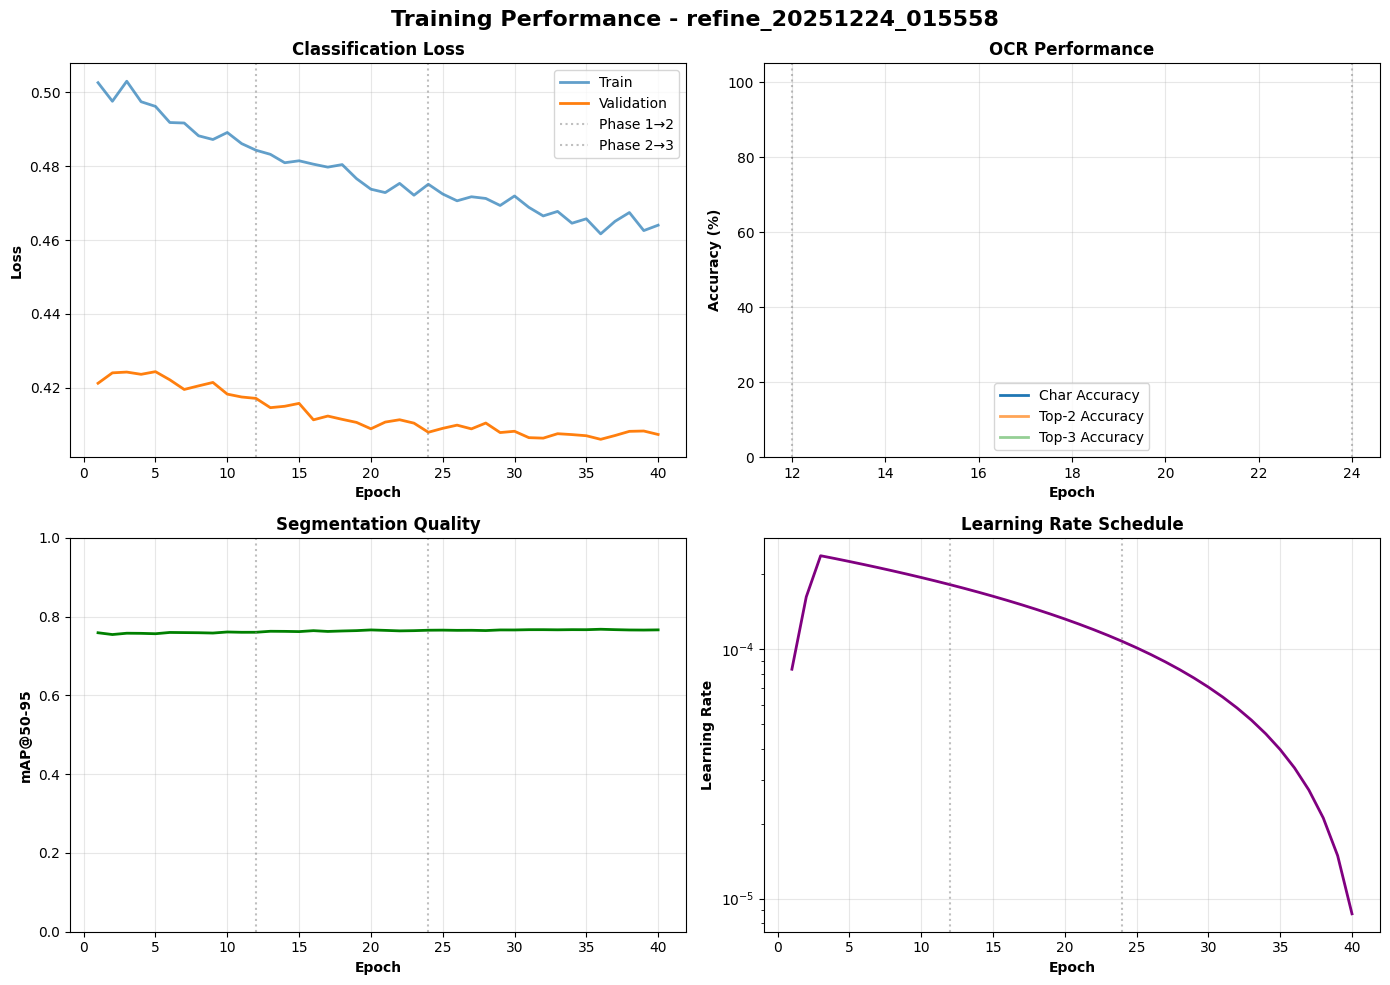

In [39]:
# Load and analyze training progress
import pandas as pd
import matplotlib.pyplot as plt

# Load progress from checkpoint manager
progress_df = checkpoint_manager.load_progress()

if not progress_df.empty:
    print('\n=== TRAINING PERFORMANCE ANALYSIS ===')
    print(f'Total epochs completed: {len(progress_df)}')

    # Get final metrics
    final_row = progress_df.iloc[-1]

    print('\nFinal Epoch Metrics:')
    print('-' * 80)

    # Classification metrics
    if 'val/cls_loss' in progress_df.columns:
        final_cls_loss = final_row['val/cls_loss']
        best_cls_loss = progress_df['val/cls_loss'].min()
        best_cls_epoch = progress_df['val/cls_loss'].idxmin() + 1

        print(f'Classification Loss:')
        print(f'  Final: {final_cls_loss:.4f}')
        print(f'  Best:  {best_cls_loss:.4f} (epoch {best_cls_epoch})')

    # OCR metrics
    if 'ocr_char_accuracy' in progress_df.columns:
        final_ocr_acc = final_row['ocr_char_accuracy']
        best_ocr_acc = progress_df['ocr_char_accuracy'].max()
        best_ocr_epoch = progress_df['ocr_char_accuracy'].idxmax() + 1

        print(f'\nOCR Character Accuracy:')
        print(f'  Final: {final_ocr_acc:.4f} ({final_ocr_acc*100:.1f}%)')
        print(f'  Best:  {best_ocr_acc:.4f} ({best_ocr_acc*100:.1f}%) (epoch {best_ocr_epoch})')

    # Segmentation metrics
    if 'metrics/mAP50-95(M)' in progress_df.columns:
        final_map = final_row['metrics/mAP50-95(M)']
        best_map = progress_df['metrics/mAP50-95(M)'].max()
        best_map_epoch = progress_df['metrics/mAP50-95(M)'].idxmax() + 1

        print(f'\nSegmentation mAP@50-95:')
        print(f'  Final: {final_map:.4f}')
        print(f'  Best:  {best_map:.4f} (epoch {best_map_epoch})')

    # Plot training curves
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Training Performance - {experiment_name}', fontsize=16, fontweight='bold')

    # Plot 1: Classification Loss
    if 'val/cls_loss' in progress_df.columns:
        ax = axes[0, 0]
        epochs = progress_df['epoch']

        if 'train/cls_loss' in progress_df.columns:
            ax.plot(epochs, progress_df['train/cls_loss'], label='Train', linewidth=2, alpha=0.7)

        ax.plot(epochs, progress_df['val/cls_loss'], label='Validation', linewidth=2)

        # Mark phase transitions
        ax.axvline(x=12, color='gray', linestyle=':', alpha=0.5, label='Phase 1→2')
        ax.axvline(x=24, color='gray', linestyle=':', alpha=0.5, label='Phase 2→3')

        ax.set_xlabel('Epoch', fontweight='bold')
        ax.set_ylabel('Loss', fontweight='bold')
        ax.set_title('Classification Loss', fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()

    # Plot 2: OCR Accuracy
    if 'ocr_char_accuracy' in progress_df.columns:
        ax = axes[0, 1]
        ax.plot(epochs, progress_df['ocr_char_accuracy'] * 100, label='Char Accuracy', linewidth=2)

        if 'ocr_top2_accuracy' in progress_df.columns:
            ax.plot(epochs, progress_df['ocr_top2_accuracy'] * 100, label='Top-2 Accuracy', linewidth=2, alpha=0.7)

        if 'ocr_top3_accuracy' in progress_df.columns:
            ax.plot(epochs, progress_df['ocr_top3_accuracy'] * 100, label='Top-3 Accuracy', linewidth=2, alpha=0.5)

        ax.axvline(x=12, color='gray', linestyle=':', alpha=0.5)
        ax.axvline(x=24, color='gray', linestyle=':', alpha=0.5)

        ax.set_xlabel('Epoch', fontweight='bold')
        ax.set_ylabel('Accuracy (%)', fontweight='bold')
        ax.set_title('OCR Performance', fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_ylim([0, 105])

    # Plot 3: Segmentation mAP
    if 'metrics/mAP50-95(M)' in progress_df.columns:
        ax = axes[1, 0]
        ax.plot(epochs, progress_df['metrics/mAP50-95(M)'], linewidth=2, color='green')

        ax.axvline(x=12, color='gray', linestyle=':', alpha=0.5)
        ax.axvline(x=24, color='gray', linestyle=':', alpha=0.5)

        ax.set_xlabel('Epoch', fontweight='bold')
        ax.set_ylabel('mAP@50-95', fontweight='bold')
        ax.set_title('Segmentation Quality', fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1])

    # Plot 4: Learning Rate
    if 'learning_rate' in progress_df.columns:
        ax = axes[1, 1]
        ax.plot(epochs, progress_df['learning_rate'], linewidth=2, color='purple')

        ax.axvline(x=12, color='gray', linestyle=':', alpha=0.5)
        ax.axvline(x=24, color='gray', linestyle=':', alpha=0.5)

        ax.set_xlabel('Epoch', fontweight='bold')
        ax.set_ylabel('Learning Rate', fontweight='bold')
        ax.set_title('Learning Rate Schedule', fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')

    plt.tight_layout()

    # Save plot
    plot_path = export_dir / 'training_analysis.png'
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f'\nTraining analysis plot saved to: {plot_path}')

    plt.show()

else:
    print('No training progress data found.')

### Key Improvements:

1. **Reproducibility**:
   - Dataset downloaded from public Google Drive folder
   - No hardcoded paths - works from any account
   - Automatic dataset verification and fixing
   
2. **Robust Checkpoint System**:
   - CSV saved EVERY epoch (no exceptions)
   - Models saved to Google Drive every epoch (if mounted)
   - Automatic resume capability
   - Threaded async saves to prevent training slowdown
   
3. **Clean Output**:
   - Clear, professional logging
   
4. **Sanity Checks**:
   - Dataset structure verification
   - File existence checks
   - Model loading error handling
   - Automatic path fixing in data.yaml